In [1]:
import os

os.sys.path.insert(0, '../script')

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from webnlg_old import WebNLGCorpus, DATASETS_FILEPATHS
%matplotlib inline

pd.set_option('max_colwidth', 1000)

import seaborn as sns

In [3]:
# datasets
DATASETS_FILEPATHS.keys()

dict_keys(['dev', 'train', 'test_no_lex', 'test_unseen_with_lex', 'test_with_lex'])

# Dataset format

## Train dataset directory tree

<img src="../img/dataset_train_directory.jpg" />

### 1triples_Airport_train_challenge.xml

<img src="../img/dataset_format_example.jpg" />

## Test dataset is all in one file, testdata_no_lex.xml

<img src="../img/dataset_test_example.jpg" />

# Dataset Stats

In [4]:
# loads datasets

train_dev = WebNLGCorpus.load(dataset=['train', 'dev'])
test_with_lex = WebNLGCorpus.load(dataset='test_with_lex')
test_unseen_with_lex = WebNLGCorpus.load(dataset='test_unseen_with_lex')

datasets = [train_dev, test_with_lex, test_unseen_with_lex]

In [5]:
# generate some statistics

datasets_stats = pd.DataFrame({
    # number of entries
    'n_entries': [len(ds) for ds in datasets],
    # number of distinct triples
    'n_distinct_triples': [ds.mdf.mtext.nunique() for ds in datasets],
    # number of distinct generated texts - if test_no_lex, returns 0
    'n_distinct_lexes': [ds.ldf.ltext.nunique() for ds in datasets],
    # number of generated texts
    'n_lexes': [ds.ldf.shape[0] for ds in datasets],
    # number of triples -> each entry can have up to 7 triples
    'n_triples': [len(ds.mdf) for ds in datasets],
    # average text length
    'avg_lexes_length': [ds.ldf.ltext.str.len().mean() for ds in datasets]
    }, index=[ds.dataset for ds in datasets])

datasets_stats

,avg_lexes_length,n_distinct_lexes,n_distinct_triples,n_entries,n_lexes,n_triples
train_dev,117.367354,20308,2131,7812,20370,23021
test_with_lex,114.805195,4922,2331,1862,4928,5378
test_unseen_with_lex,110.532676,2430,1068,891,2433,2450


## Is there any duplicated lexicalized text?

Here I test if there are two or more different entries with the same lexicalization.

In [6]:
# group by ltext
#    counts uniques idx(entry identifier) inside a group
lexis_counts = train_dev.ldf.groupby('ltext').idx.unique().apply(len)

# some examples of lexicalizations that occur in different entries
lexis_counts.nlargest(5)

ltext
Barack Obama is the leader of the United States.                                                                    3
Joe Biden is a United States leader.                                                                                3
Joe Biden is a leader of the United States.                                                                         3
St Vincent-St Mary High School, Akron, Summit County, Ohio, United States is the ground of Akron Summit Assault.    3
103 Colmore Row was completed in 1976.                                                                              2
Name: idx, dtype: int64

In [7]:
print("There are {} lexicalizations that occurs in more than one entry. The ammount of 'duplicated' lexicalizations is {}"\
      .format(
        len(lexis_counts[lexis_counts > 1]), 
        lexis_counts[lexis_counts > 1].sum()
      ))

There are 58 lexicalizations that occurs in more than one entry. The ammount of 'duplicated' lexicalizations is 120


#### Let's analyze some example

In [8]:
# gets the idx of entrys which lexicalization is Barack Obama is the leader of the United States.
barack_obama_idx = train_dev.ldf[train_dev.ldf.ltext == 'Barack Obama is the leader of the United States.'].idx

# prints those entries

for idx in barack_obama_idx:
    
    print(train_dev.sample(idx=idx))
    print('\n\n---------------------------------------------------------------------------------------\n\n')

Triple info: {'category': 'Building', 'eid': 'Id232', 'idx': '3_231', 'ntriples': 1}

	Modified triples:

United_States | leaderName | Barack_Obama


	Lexicalizations:

The leader of the United States was Barack Obama.
Barack Obama is the leader of the U.S.
Barack Obama is the leader of the United States.


---------------------------------------------------------------------------------------


Triple info: {'category': 'WrittenWork', 'eid': 'Id211', 'idx': '4_210', 'ntriples': 1}

	Modified triples:

United_States | leaderName | Barack_Obama


	Lexicalizations:

The leader of the United States is Barack Obama.
Barack Obama is the leader of the United States.
Barack Obama is the president of the US.


---------------------------------------------------------------------------------------


Triple info: {'category': 'Food', 'eid': 'Id267', 'idx': '5_266', 'ntriples': 1}

	Modified triples:

United_States | leaderName | Barack_Obama


	Lexicalizations:

Barack Obama is a leader of the U

<img src="../img/barack_obama_food.jpg" />

Is Barack Obama a Food? I've sent an e-mail to Anastasia Shimorina.

<img src="../img/barack_obama_food_explanation.jpg" />

One example of entry among the Food category that contains the triple United_States | leader | Barack_Obama:

<img src="../img/barack_obama_food2.jpg" />

So, every triple in the Xtriplesize_category, X > 1, is in 1triplesize_category ?
    
Let's test.

! I'm putting dev and train together !

In [ ]:
from config import CATEGORIES

for category in CATEGORIES:
    
    print("Testing category: [{}]".format(category))
    
    triple_1_entries = train_dev.subset(ntriples=[1], categories=[category]).mdf
    
    triple_gt1_entries = train_dev.subset(ntriples=[2, 3, 4, 5, 6, 7], categories=[category]).mdf
    
    not_in_triple1 = triple_gt1_entries[~triple_gt1_entries.mtext.isin(triple_1_entries.mtext)]
    
    print("Number of triples in X>1 tripleset that aren't in 1 tripleset: [{}]"\
          .format(len(not_in_triple1.mtext.unique())))
    if len(not_in_triple1):
        
        triple_sample = not_in_triple1.sample()
        print('Example of triple: ', triple_sample.mtext.values[0])
        sample = train_dev.sample(idx=triple_sample.idx.values[0])
        print('\n')
        print(sample)
        
    print('\n')

So, there are triples in X>1 triplesets datasets wich doesn't occur in the respective 1 tripleset dataset, of the same category.

### And what about if all triples in Xtriple set are in 1triple set?

In [10]:
triple_1 = train_dev.subset(ntriples=[1]).mdf
triples_gt1 = train_dev.subset(ntriples=[2, 3, 4, 5, 6, 7]).mdf

in_gt1_not_1 = triples_gt1[~triples_gt1.mtext.isin(triple_1.mtext)]

print("There are {} distinct triples in X>1 datasets that aren't in 1 datasets"\
      .format(len(in_gt1_not_1.mtext.unique())))

There are 176 distinct triples in X>1 datasets that aren't in 1 datasets


In [11]:
sample = in_gt1_not_1.sample()

print('Triple: {}'.format(sample.mtext.values[0]))

print('\n')

print(train_dev.sample(idx=sample.idx.values[0]))

Triple: Ardmore_Airport_(New_Zealand) | runwayLength | 518.0


Triple info: {'category': 'Airport', 'eid': 'Id137', 'idx': '49_136', 'ntriples': 3}

	Modified triples:

Ardmore_Airport_(New_Zealand) | 3rd_runway_SurfaceType | Poaceae
Ardmore_Airport_(New_Zealand) | elevationAboveTheSeaLevel_(in_metres) | 34.0
Ardmore_Airport_(New_Zealand) | runwayLength | 518.0


	Lexicalizations:

The 3rd runway at Ardmore Airport in New Zealand (which is 34 meters above sea level ) is made of Poaceae and has a length of 518.0.
Ardmore Airport (New Zealand) is 34 metres above sea level, a runway length of 518, and a 3rd runway surfaced with poaceae.
The 3rd runway at Ardmore Airport (New Zealand) is made of Poaceae. It is 34 m above sea level and its length is 518 feet.


So, there are triples in X>1 datasets that don't occur in 1 datasets at all. This impacts my approach of generating templates with 1 datasets only :)

### Now, all 1triple set occur in X>1?

In [12]:
in_1_not_gt1 = triple_1[~triple_1.mtext.isin(triples_gt1.mtext)]

print("There are {} distinct triples in 1 datasets that aren't in X>1 datasets"\
      .format(len(in_1_not_gt1.mtext.unique())))

There are 312 distinct triples in 1 datasets that aren't in X>1 datasets


In [13]:
sample = in_1_not_gt1.sample()

print('Triple: {}'.format(sample.mtext.values[0]))

print('\n')

print(train_dev.sample(idx=sample.idx.values[0]))

Triple: Ashgabat_International_Airport | 1st_runway_LengthFeet | 12467


Triple info: {'category': 'Airport', 'eid': 'Id172', 'idx': '0_171', 'ntriples': 1}

	Modified triples:

Ashgabat_International_Airport | 1st_runway_LengthFeet | 12467


	Lexicalizations:

The length of the first runway at Ashgabat International Airport is 12467 feet.
The 1st runway at Ashgabat International airport is 12467 feet in length.
Ashgabat International Airport's 1st runway has a length of 12467 feet.


## Distribution per category and number of triples

In [14]:
def heatmap_by_category_ntriples(ds):
    
    # makes a figure
    _, ax = plt.subplots(1, 1, figsize=(8, 8))
    # heatmap of counts per category x ntriples
    sns.heatmap(pd.crosstab(ds.category, ds.ntriples), 
                # annotate counts
                annot=True,
                ax=ax,
                # integer formatting
                fmt='d',
                cmap='Blues')

### train_dev

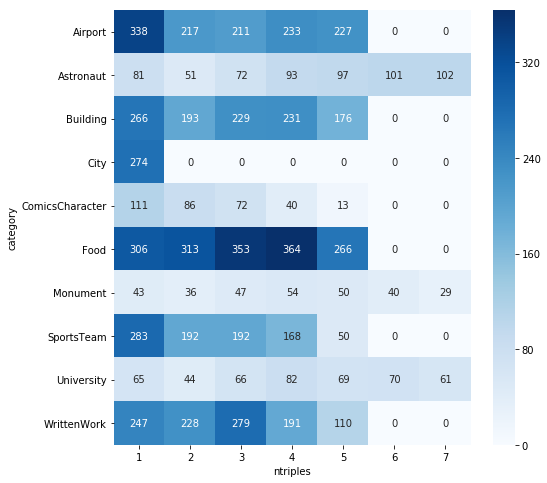

In [15]:
heatmap_by_category_ntriples(train_dev.edf)

### test_unseen_with_lex

unseen categories

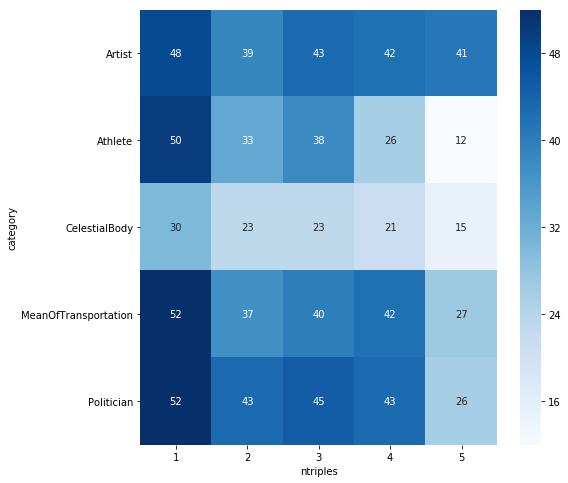

In [17]:
heatmap_by_category_ntriples(test_unseen_with_lex.edf)

# Have a look at a sample

In [18]:
train_dev.sample(category='Astronaut', ntriples=1, random_state=100)

Triple info: {'category': 'Astronaut', 'eid': 'Id12', 'idx': '7_11', 'ntriples': 1}

	Modified triples:

Alan_Shepard | birthDate | "1923-11-18"


	Lexicalizations:

Alan Shepard was born November 18th, 1923.
Alan Shepard was born on November 18, 1923.
Alan Shepard was born on Nov 18, 1923.
Alan Shepard was born on 1923-11-18.
Alan Shepard was born on the 18th of November 1923.

# Is there any duplicates?

## Is there any modified triple duplicated in a tripleset?

No

In [21]:
# count how many entries has duplicated mtriples among its mtriples
def n_duplicated_mtriples_per_entry(ds):
    
    # group by
    #    idx, mtext -> if there is a group with more than 1 element
    #       it means that there are duplicateds mtext(mtext) in a tripleset(idx)
    mtriples_count_per_entry = ds.mdf.groupby(['idx', 'mtext']).size()
    
    # sum(true = 1 false = 0) the cases of duplications
    return (mtriples_count_per_entry > 1).sum()

In [22]:
pd.Series({dataset.dataset: n_duplicated_mtriples_per_entry(dataset)
             for dataset in datasets},
          name='number of cases of triples duplicated in a tripleset')

test_unseen_with_lex    0
test_with_lex           0
train_dev               0
Name: number of cases of triples duplicated in a tripleset, dtype: int64

## Is there any modified triple duplicated among all entries?

yes

In [23]:
# counts, for each mtriple, in how many entries it occurs
def mtriples_count(ds):
    
    return ds.mdf.mtext.value_counts()

def mtriples_count_describe(ds):
    
    s = mtriples_count(ds).describe()
    s.name = ds.dataset
    
    return s

In [24]:
# ex: on average, each triple of train_dev dataset occurs in 10.8 entries
#     on maximum, 123 times
pd.concat([mtriples_count_describe(ds) for ds in datasets], axis=1)

,train_dev,test_with_lex,test_unseen_with_lex
count,2131.000000,2331.000000,1068.000000
mean,10.802909,2.307164,2.294007
std,13.211164,2.216992,1.641108
min,1.000000,1.000000,1.000000
25%,3.000000,1.000000,1.000000
50%,7.000000,2.000000,2.000000
75%,13.000000,3.000000,3.000000
max,123.000000,39.000000,10.000000


In [25]:
# most frequent triples in train dataset

cm_train = mtriples_count(train_dev)

cm_train.head(3)

English_language | spokenIn | Great_Britain    123
United_States | capital | Washington,_D.C.     105
United_States | language | English_language    102
Name: mtext, dtype: int64

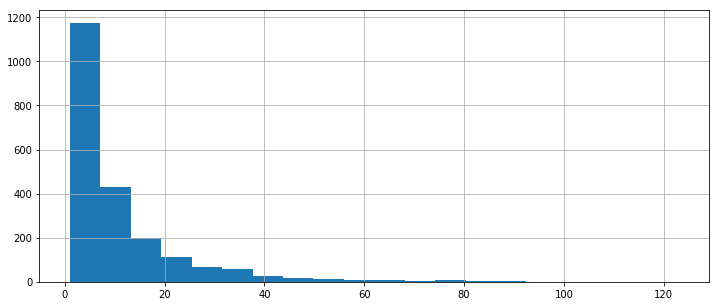

In [26]:
mtriples_count(train_dev).hist(bins=20, figsize=(12, 5))

## Are entries with shared triples lexicalized the same way?

Remember that the same triple can appear in more than one entry.

There are some patterns...

In [27]:
# groups by mtext and lists the lexicalizations
def mtriples_with_generated_lexes(ds):
    
    # merges modified triple dataset and lexicalization dataset
    df = pd.merge(ds.mdf, ds.ldf)
    
    # groups by triple and for each triple generates a list of lexicalizations
    ddf = df.groupby('mtext').ltext.apply(list).to_frame()
    # adds a column with the number of lexicalizations
    ddf['size'] = ddf.ltext.apply(len)
    
    return ddf

# prints triple and its lexicalizations
def print_mtriple_with_generated_lexes(mtriple):
    
    print("triple: ", mtriple.name, '\n')
    for ltext in mtriple.ltext:
        print("lexicalization: ", ltext, '\n')

### train_dev

For example: 

* *11_Diagonal_Street | floorArea | 1200 (square metres)* appears in entries with eids 3_14(size = 1) and 29_14(size = 4)

In [28]:
train_dev.sample(idx='29_14')

Triple info: {'category': 'Building', 'eid': 'Id15', 'idx': '29_14', 'ntriples': 4}

	Modified triples:

11_Diagonal_Street | completionDate | 1983
11_Diagonal_Street | floorCount | 20
11_Diagonal_Street | architect | Helmut_Jahn
11_Diagonal_Street | floorArea | 1200 (square metres)


	Lexicalizations:

The architect of 11 Diagonal Street is Helmut Jahn and it was completed in 1983. It has 20 floors and a floor area of 1200 square metres.
11 Diagonal Street was designed by Helmut Jahn and was completed in 1983. It has 20 floors and an area of 1200 square metres.
Helmut Jahn was the architect of 11 Diagonal Street which was completed in 1983 with 20 floors and a total floor area of 1200 square metres.

In [29]:
train_dev.sample(idx='3_14')

Triple info: {'category': 'Building', 'eid': 'Id15', 'idx': '3_14', 'ntriples': 1}

	Modified triples:

11_Diagonal_Street | floorArea | 1200 (square metres)


	Lexicalizations:

11 Diagonal Street has a floor area of 1200 square metres.

In [30]:
mtriples_w_lexes_train = mtriples_with_generated_lexes(train_dev)

In [31]:
# on average, each triple occurs in 28 lexicalizations
# on maximum, 319
mtriples_w_lexes_train['size'].describe()

count    2131.000000
mean       28.432191
std        34.977128
min         1.000000
25%         6.000000
50%        17.000000
75%        36.000000
max       319.000000
Name: size, dtype: float64

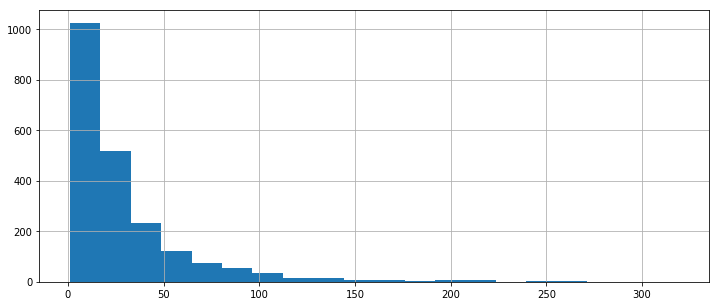

In [32]:
mtriples_w_lexes_train['size'].hist(bins=20, figsize=(12, 5))

In [33]:
# some examples of triples that are lexicalizad in more than one way
mtriples_w_lexes_train_size_lt_5 = mtriples_w_lexes_train[mtriples_w_lexes_train['size'] < 5]

print_mtriple_with_generated_lexes(mtriples_w_lexes_train_size_lt_5.iloc[0, :])

triple:  11_Diagonal_Street | floorArea | 1200 (square metres) 

lexicalization:  11 Diagonal Street has a floor area of 1200 square metres. 

lexicalization:  The architect of 11 Diagonal Street is Helmut Jahn and it was completed in 1983. It has 20 floors and a floor area of 1200 square metres. 

lexicalization:  11 Diagonal Street was designed by Helmut Jahn and was completed in 1983. It has 20 floors and an area of 1200 square metres. 

lexicalization:  Helmut Jahn was the architect of 11 Diagonal Street which was completed in 1983 with 20 floors and a total floor area of 1200 square metres. 



In [ ]:
# some examples of triples that are lexicalizad in more than a hundred ways
mtriples_w_lexes_train_size_lt_5 = mtriples_w_lexes_train[mtriples_w_lexes_train['size'] > 100]

print_mtriple_with_generated_lexes(mtriples_w_lexes_train_size_lt_5.iloc[0, :])

### test_with_lex

no, you mustn't see the test data

# And what about lexicalizations for same predicates?

In [35]:
# groups by m_predicate and lists the lexicalizations
def m_predicates_with_generated_lexes(ds):
    
    # merges modified triple dataset and lexicalization dataset
    df = pd.merge(ds.mdf, ds.ldf)
    
    # groups by triple and for each triple generates a list of lexicalizations
    ddf = df.groupby('m_predicate').ltext.apply(list).to_frame()
    # adds a column with the number of lexicalizations
    ddf['size'] = ddf.ltext.apply(len)
    
    return ddf

# prints triple and its lexicalizations
def print_m_predicate_with_generated_lexes(mtriple):
    
    print("m_predicate: ", mtriple.name, '\n')
    for ltext in sorted(mtriple.ltext):
        print("lexicalization: ", ltext, '\n')

In [36]:
m_predicates_w_lexes_train = m_predicates_with_generated_lexes(train_dev)

In [37]:
# on average, each predicate occurs in 246 lexicalizations
# on maximum, 6345

m_predicates_w_lexes_train['size'].describe()

count     246.000000
mean      246.296748
std       597.935924
min         1.000000
25%        20.000000
50%        67.000000
75%       219.500000
max      6345.000000
Name: size, dtype: float64

In [38]:
# who is the biggest guys?

m_predicates_w_lexes_train.nlargest(20, 'size').reset_index()[['m_predicate', 'size']]

,m_predicate,size
0,country,6345
1,location,4046
2,leaderName,3537
3,ingredient,1930
4,region,1673
5,isPartOf,1640
6,language,1596
7,ethnicGroup,1524
8,birthPlace,1281
9,club,1145


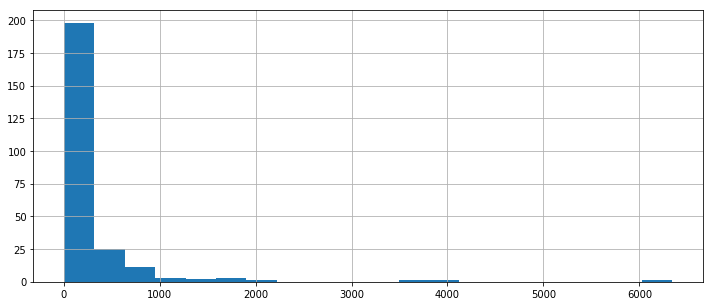

In [39]:
m_predicates_w_lexes_train['size'].hist(bins=20, figsize=(12, 5))

In [40]:
# one example of a predicate lexicalized less than 10 times
m_predicates_w_lexes_train_size_lt_5 = m_predicates_w_lexes_train[m_predicates_w_lexes_train['size'] < 10]

print_m_predicate_with_generated_lexes(m_predicates_w_lexes_train_size_lt_5.sample().iloc[0, :])

m_predicate:  4th_runway_SurfaceType 

lexicalization:  Amsterdam Airport Schiphol is -3.3528 metres above sea level and the 4th runway is made of asphalt. 

lexicalization:  Amsterdam Airport Schiphol is 3.3528 below sea level and its fourth runway is made from asphalt. 

lexicalization:  Andrews County Airport is 973 metres above sea level and The 4th runway is made of Asphalt. 

lexicalization:  The 4th runway at Amsterdam Airport Schipol has a surface of asphalt. 

lexicalization:  The 4th runway at Andrews County Airport is made of Asphalt. 

lexicalization:  The Andrews County Airport fourth runway is made of asphalt. 

lexicalization:  The fourth runway at Andrews County Airport is made from asphalt. 

lexicalization:  The fourth runway at Andrews County Airport is made of asphalt and the airport is 973 below sea level. 

lexicalization:  The fourth runway at Schiphol Airport in Amsterdam is made of asphalt. 



In [ ]:
# one example of a predicate lexicalized more than 6k times
m_predicates_w_lexes_train_size_lt_5 = m_predicates_w_lexes_train[m_predicates_w_lexes_train['size'] > 6000]

print_m_predicate_with_generated_lexes(m_predicates_w_lexes_train_size_lt_5.sample().iloc[0, :])

## Number of distinct subjects, predicates, objects

### for each dataset

In [42]:
def report_n_distinct_s_p_o(mdf):
    
    return {'subject': mdf.m_subject.nunique(),
            'predicate': mdf.m_predicate.nunique(),
            'object': mdf.m_object.nunique(),
            # defined as a subject ou object
            'subject_and_object': pd.concat([mdf.m_subject, mdf.m_object]).nunique(),
            # vocabulary size
            'vocabulary': pd.concat([mdf.m_subject, mdf.m_object, mdf.m_predicate]).nunique()
           }

In [43]:
df = pd.DataFrame(data = [report_n_distinct_s_p_o(ds.mdf) for ds in datasets],
             index = [ds.dataset for ds in datasets])

df['unique_triples'] = [ds.mdf.mtext.nunique() for ds in datasets]
df

,object,predicate,subject,subject_and_object,vocabulary,unique_triples
train_dev,1642,246,434,1771,2017,2131
test_with_lex,1888,300,575,2125,2425,2331
test_unseen_with_lex,898,159,238,1002,1161,1068


### among all datasets

In [44]:
pd.DataFrame(report_n_distinct_s_p_o(pd.concat([ds.mdf for ds in datasets])),
             index=['all'])

,object,predicate,subject,subject_and_object,vocabulary
all,2505,354,667,2730,3084


## Most frequent subjects, predicates, objects

in relation to amount of entries in which they occur, not the amount of lexicalizations where they appear(remember that an entry can have more than one lexicalization)

In [45]:
def most_frequent(ds, type_, n=5):
    
    if type_ == 'subject':
        return ds.mdf.m_subject.value_counts().nlargest(n)
    if type_ == 'object':
        return ds.mdf.m_object.value_counts().nlargest(n)
    if type_ == 'predicate':
        return ds.mdf.m_predicate.value_counts().nlargest(n)

### train_dev

In [46]:
most_frequent(train_dev, 'subject')

United_States                      760
Acharya_Institute_of_Technology    539
Alan_Shepard                       478
Elliot_See                         474
Alan_Bean                          410
Name: m_subject, dtype: int64

In [47]:
most_frequent(train_dev, 'object')

United_States       944
English_language    294
Indonesia           185
Spain               169
Italy               142
Name: m_object, dtype: int64

In [48]:
most_frequent(train_dev, 'predicate')

country       2409
location      1537
leaderName    1385
ingredient     738
isPartOf       641
Name: m_predicate, dtype: int64

## Distribution of vocabulary

### m_subject

In [49]:
m_subject_vc = train_dev.mdf.m_subject.value_counts()

m_subject_vc.describe(percentiles=[.5, .75, .9, .99])

count    434.000000
mean      53.043779
std       79.166678
min        1.000000
50%       20.000000
75%       79.750000
90%      124.000000
99%      409.670000
max      760.000000
Name: m_subject, dtype: float64

* 50% dos m_subject ocorrem 20 ou menos vezes
* 50% dos m_subject ocorrem 21 ou mais vezes

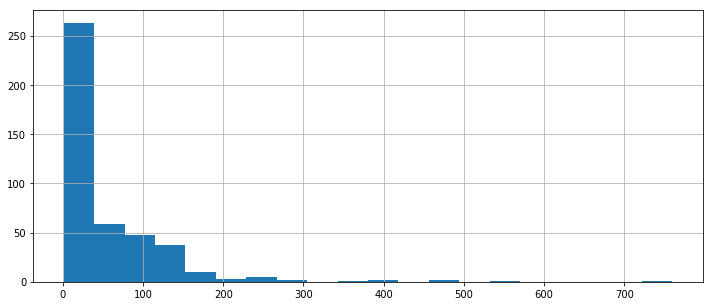

In [50]:
m_subject_vc.hist(bins=20, figsize=(12, 5))

### m_predicate

In [51]:
m_predicate_vc = train_dev.mdf.m_predicate.value_counts()

m_predicate_vc.describe(percentiles=[.5, .75, .9, .99])

count     246.000000
mean       93.581301
std       228.610263
min         1.000000
50%        25.000000
75%        80.000000
90%       228.000000
99%      1093.850000
max      2409.000000
Name: m_predicate, dtype: float64

* 50% dos m_predicate ocorrem 25 ou menos vezes
* 50% dos m_predicate ocorrem 26 ou mais vezes

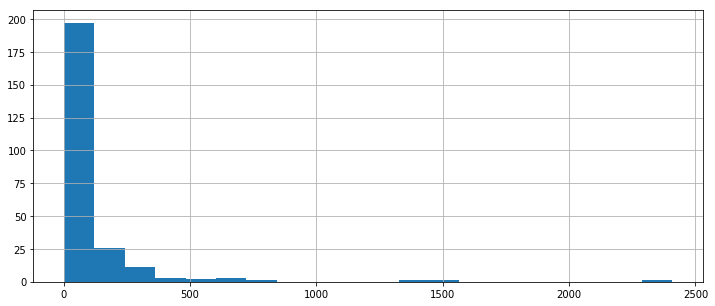

In [52]:
m_predicate_vc.hist(bins=20, figsize=(12, 5))

### m_object

In [53]:
m_object_vc = train_dev.mdf.m_object.value_counts()

m_object_vc.describe(percentiles=[.5, .75, .9, .99])

count    1642.000000
mean       14.020097
std        30.023659
min         1.000000
50%         7.000000
75%        16.000000
90%        31.000000
99%        93.180000
max       944.000000
Name: m_object, dtype: float64

* 50% dos m_object ocorrem 7 ou menos vezes
* 50% dos m_object ocorrem 8 ou mais vezes

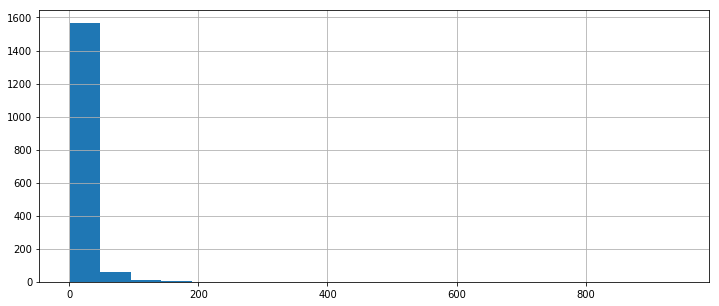

In [54]:
m_object_vc.hist(bins=20, figsize=(12, 5))

# Is tripleset connected?

is there a path between any pair of triples?

## Let's check a sample

### non connected example

This example looks like a case of verbalization containing more information than data!

Triple info: {'category': 'Food', 'eid': 'Id186', 'idx': '25_185', 'ntriples': 4}

	Modified triples:

Batagor | country | Indonesia
Siomay | dishVariation | Shumai
Shumai | dishVariation | Siomay
Batagor | ingredient | Peanut_sauce


	Lexicalizations:

Batagor comes from Indonesia, it includes peanut sauce and is a variation on Shumai/Siomay.
Shumai is a variation of Siomay and they are both types of the same dish. Batagor is found in Indonesia and has peanut sauce as an ingredient.
Batagor, a variant of Shumai and Siomay, contains peanut sauce and originates from Indonesia.


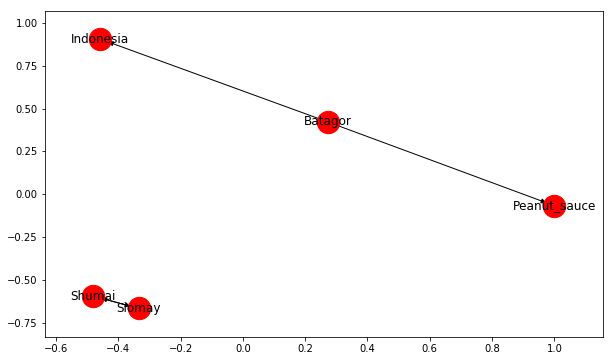

In [55]:
s = train_dev.sample(idx='25_185')

print(s)
s.draw_graph()

### connected example

Triple info: {'category': 'Food', 'eid': 'Id101', 'idx': '25_100', 'ntriples': 4}

	Modified triples:

Bacon_sandwich | dishVariation | BLT
BLT | dishVariation | Club_sandwich
Bacon_sandwich | ingredient | Condiment
Bacon_sandwich | country | United_Kingdom


	Lexicalizations:

The country that bacon sandwich comes from is the United Kingdom. It can be served with condiments and variations include the BLT and club sandwich.
Bacon sandwich is a dish from the United Kingdom and condiments are used to prepare it.BLT is a variation of a Club Sandwich.
The BLT is a bacon sandwich, a variant of the Club sandwich. The bacon sandwich uses condiments and originates from the United Kingdom.


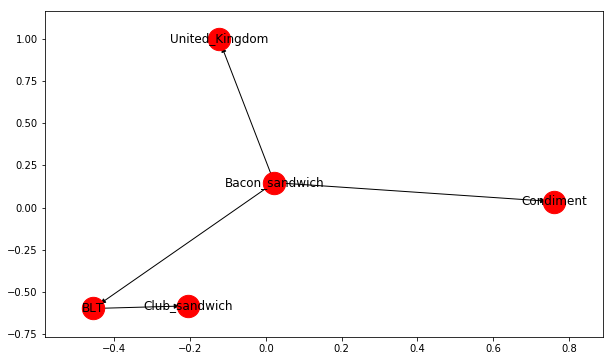

In [56]:
s = train_dev.sample(idx='25_100')

print(s)
s.draw_graph()

## Let's check all tripleset

In [57]:
import networkx as nx

def entries_is_connected_df(mdf):

    is_connected = []

    for idx, entry_group in mdf.groupby('idx'):

        entry_group.reset_index(inplace=True)

        d_g = nx.from_pandas_edgelist(entry_group, 'm_subject', 'm_object', 'm_predicate', create_using=nx.DiGraph())
        u_g = nx.Graph(d_g)

        is_connected.append([idx, nx.is_connected(u_g)])

    is_connected_df = pd.DataFrame(is_connected, columns=['idx', 'is_connected'])
    
    return is_connected_df.is_connected.value_counts()

### train_dev

In [58]:
entries_is_connected_df(train_dev.mdf)

True     7800
False      12
Name: is_connected, dtype: int64

### test_unseen_with_lex

In [59]:
entries_is_connected_df(test_with_lex.mdf)

True     1858
False       4
Name: is_connected, dtype: int64

# Is it possible to determine a 'root' entity?

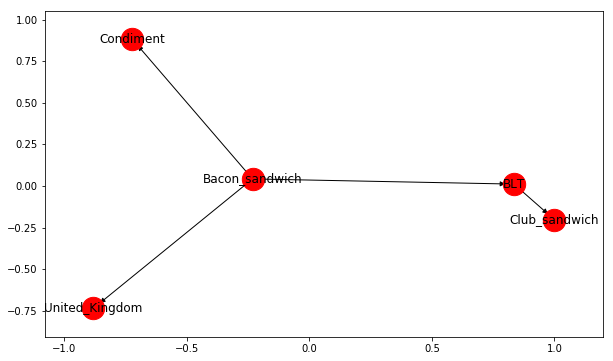

In [60]:
entry = train_dev.sample(idx='25_100')
entry.draw_graph()

In [61]:
sorted(entry.graph.degree, key=lambda x: x[1], reverse=True)

[('Bacon_sandwich', 3),
 ('BLT', 2),
 ('Club_sandwich', 1),
 ('Condiment', 1),
 ('United_Kingdom', 1)]

# Typos

"Afonso Pena International Airport ICAO Location **Idenitifier** is SBCT."

rather than

"Afonso Pena International Airport ICAO Location **Identifier** is SBCT."

In [62]:
test_with_lex = WebNLGCorpus.load(dataset='test_with_lex')

In [63]:
e = test_with_lex.sample(idx='0_3')
e

Triple info: {'category': 'Airport', 'eid': 'Id4', 'idx': '0_3', 'ntriples': 1}

	Modified triples:

Afonso_Pena_International_Airport | ICAO_Location_Identifier | "SBCT"


	Lexicalizations:

Afonso Pena International Airport ICAO Location Idenitifier is SBCT.
SBCT is the ICAO location identifier of Afonso Pena International Airport.

In [64]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

s_multiwordexpressions = test_with_lex.mdf.m_subject.str.lower().str.replace('_', ' ').str.split().tolist()
o_multiwordexpressions = test_with_lex.mdf.m_object.str.lower().str.replace('_', ' ').str.split().tolist()

all_multiwordexpressions = s_multiwordexpressions + o_multiwordexpressions
all_multiwordexpressions = list(set([tuple(s) for s in all_multiwordexpressions]))

from nltk.tokenize.mwe import MWETokenizer

t = MWETokenizer(all_multiwordexpressions)

from textacy.preprocess import preprocess_text

def preprocess(ref):
    
    ref = preprocess_text(ref, no_accents=True, lowercase=True, no_punct=True)
    
    return t.tokenize(ref.split())

cc = SmoothingFunction()
def bleu(e, text):
    
    references = [preprocess(ref) for ref in e.ldf.ltext.tolist()]

    # TODO: same smoothing as Moses?
    return sentence_bleu(references, preprocess(text), smoothing_function=cc.method3)

In [65]:
bleu(e, 'Afonso Pena International Airport ICAO Location Identifier is SBCT.')

0.5081327481546147

In [66]:
bleu(e, 'Afonso Pena International Airport ICAO Location Idenitifier is SBCT.')

1.0